# pyspark and geopands

This is a demo for showing pyspark and geopands

In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib


matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 20)

from retrying import retry # for exponential back down when calling TurboOverdrive API

import pyspark.sql.functions as func # resuse as func.coalace for example
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType
from pyspark.sql import SparkSession

import pandas as pd
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
from ast import literal_eval as make_tuple # used to decode data from java


In [2]:
# Create SparkSession and attach Sparkcontext to it
spark = SparkSession.builder.appName("pyspark-geopandas-demo").getOrCreate()
sc = spark.sparkContext

In [3]:
#   -- input --
import shapefile
!pwd

sf = shapefile.Reader(r'./states/states')
print ('number of shapes imported: ', len(sf.shapes()))

/home/jovyan/work/bigdata/geospatial_libs
number of shapes imported:  49


In [4]:
shapes  = sf.shapes()
shapes

Shapes: [<shapefile.Shape object at 0x7effb71ee3c8>, <shapefile.Shape object at 0x7effb71ee588>, <shapefile.Shape object at 0x7effbc5aad30>, <shapefile.Shape object at 0x7effb72c1eb8>, <shapefile.Shape object at 0x7efff0697a90>, <shapefile.Shape object at 0x7effb71ee438>, <shapefile.Shape object at 0x7effb719e358>, <shapefile.Shape object at 0x7effb71ee390>, <shapefile.Shape object at 0x7effb719e2e8>, <shapefile.Shape object at 0x7effb719e518>, <shapefile.Shape object at 0x7effb719e5c0>, <shapefile.Shape object at 0x7effbc577278>, <shapefile.Shape object at 0x7efff0697e48>, <shapefile.Shape object at 0x7efff0697dd8>, <shapefile.Shape object at 0x7efff0697a58>, <shapefile.Shape object at 0x7effb71ee0b8>, <shapefile.Shape object at 0x7efff063a7b8>, <shapefile.Shape object at 0x7efff063a470>, <shapefile.Shape object at 0x7efff063a940>, <shapefile.Shape object at 0x7efff063a710>, <shapefile.Shape object at 0x7efff063a828>, <shapefile.Shape object at 0x7efff063a438>, <shapefile.Shape object

In [5]:
# Load the boundaries data
geo_df = GeoDataFrame.from_file('./states/')

In [6]:
for name in dir(shapes[5]):
    if not name.startswith('__'):
        print (name)

_from_geojson
bbox
parts
points
shapeType
shapeTypeName


In [7]:
geo_df

,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,LAND_KM,WATER_KM,PERSONS,FAMILIES,HOUSHOLD,MALE,...,CARPOOL,PUBTRANS,EMPLOYED,UNEMPLOY,SERVICE,MANUAL,P_MALE,P_FEMALE,SAMP_POP,geometry
0,Illinois,17,E N Cen,IL,143986.610,1993.335,11430602.0,2924880.0,4202240.0,5552233.0,...,652603.0,538071.0,5417967.0,385040.0,1360159.0,828906.0,0.486,0.514,1747776.0,"POLYGON ((-88.07156 37.51099, -88.08788 37.476..."
1,District of Columbia,11,S Atl,DC,159.055,17.991,606900.0,122087.0,249634.0,282970.0,...,36621.0,111422.0,303994.0,23442.0,65498.0,22407.0,0.466,0.534,72696.0,"POLYGON ((-77.00823 38.96656, -76.91121 38.889..."
2,Delaware,10,S Atl,DE,5062.456,1385.022,666168.0,175867.0,247497.0,322968.0,...,42968.0,8069.0,335147.0,13945.0,87973.0,44140.0,0.485,0.515,102776.0,"POLYGON ((-75.70742 38.55748, -75.71106 38.649..."
3,West Virginia,54,S Atl,WV,62384.200,375.199,1793477.0,500259.0,688557.0,861536.0,...,106918.0,7237.0,671085.0,71142.0,205950.0,124172.0,0.480,0.520,317564.0,"POLYGON ((-79.23190 38.48037, -79.27260 38.437..."
4,Maryland,24,S Atl,MD,25316.345,6188.794,4781468.0,1245814.0,1748991.0,2318671.0,...,376449.0,202169.0,2481342.0,111536.0,586994.0,260308.0,0.485,0.515,684773.0,"MULTIPOLYGON (((-75.71106 38.64955, -75.70742 ..."
5,Colorado,08,Mtn,CO,268659.501,960.364,3294394.0,854214.0,1282489.0,1631295.0,...,210274.0,46983.0,1633281.0,99438.0,421079.0,181760.0,0.495,0.505,512677.0,"POLYGON ((-102.04400 37.64146, -102.04156 37.3..."
6,Kentucky,21,E S Cen,KY,103961.904,1772.542,4551524.0,1237346.0,1718663.0,2195130.0,...,273091.0,48158.0,1970934.0,148125.0,556744.0,361621.0,0.482,0.518,646517.0,"MULTIPOLYGON (((-86.51067 36.65503, -86.77054 ..."
7,Kansas,20,W N Cen,KS,211921.641,1188.865,2477574.0,658600.0,944726.0,1214645.0,...,135598.0,7585.0,1172214.0,57772.0,346339.0,166429.0,0.490,0.510,453411.0,"POLYGON ((-95.07169 37.00141, -95.40637 37.000..."
8,Virginia,51,S Atl,VA,102537.328,4263.820,6180651.0,1627615.0,2289067.0,3030948.0,...,499251.0,125792.0,3025109.0,141926.0,777181.0,420070.0,0.490,0.510,898089.0,"MULTIPOLYGON (((-79.14432 36.54606, -79.21706 ..."
9,Missouri,29,W N Cen,MO,178445.951,2100.115,5117073.0,1368334.0,1961206.0,2464315.0,...,312042.0,47129.0,2367395.0,155388.0,659782.0,386746.0,0.482,0.518,864999.0,"POLYGON ((-89.10497 36.95387, -89.12959 36.866..."


In [8]:
# Get the bounding box of the 5th shape.
# Round coordinates to 3 decimal places
bbox = shapes[5].bbox
print (['%.3f' % coord for coord in bbox])

['-109.055', '36.989', '-102.037', '41.003']


In [9]:
def plot(sf):

    #   -- plot --
    fig     = plt.figure()
    ax      = fig.add_subplot(111)
    ax.get_yaxis().set_visible(True)
    ax.get_xaxis().set_visible(True)
    ax.set_frame_on(False)

    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y)

    plt.show()

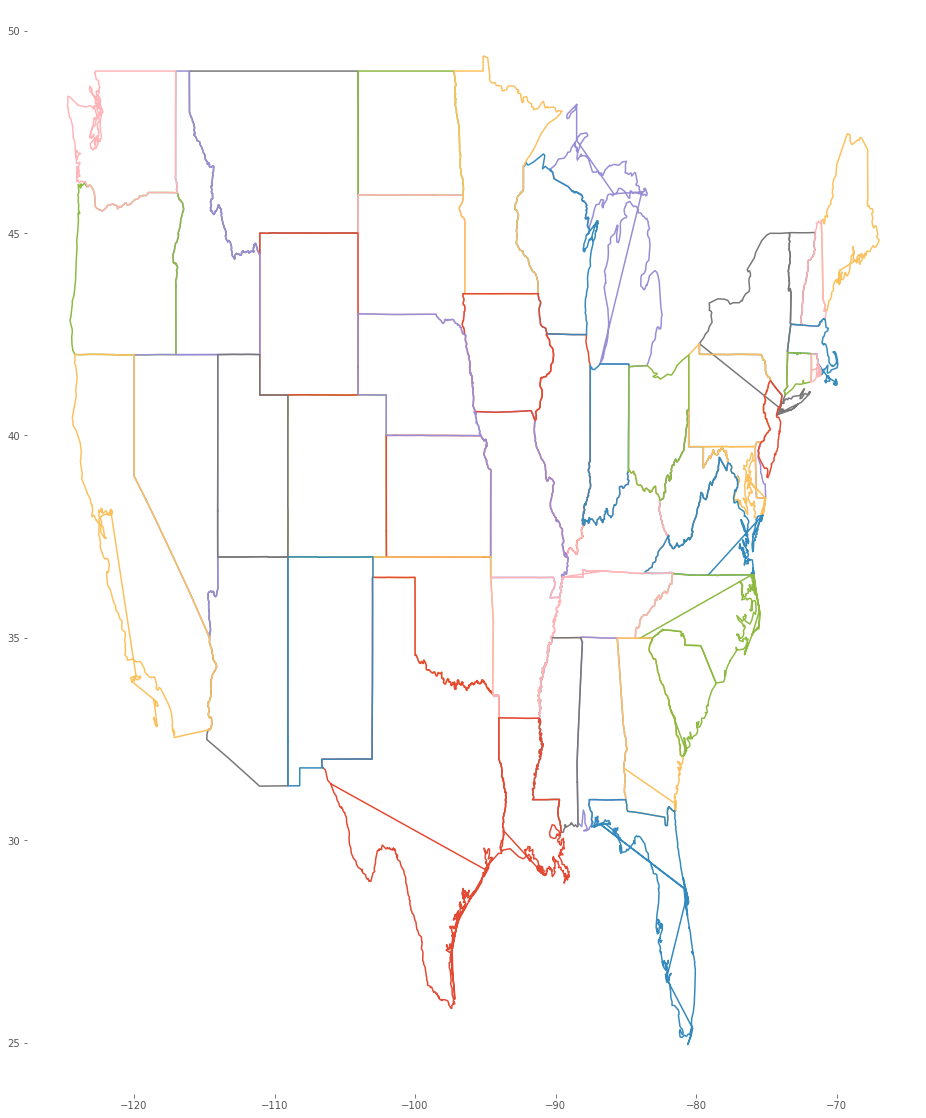

In [10]:

plot(sf)

In [11]:
geo_df.columns

Index(['STATE_NAME', 'STATE_FIPS', 'SUB_REGION', 'STATE_ABBR', 'LAND_KM',
       'WATER_KM', 'PERSONS', 'FAMILIES', 'HOUSHOLD', 'MALE', 'FEMALE',
       'WORKERS', 'DRVALONE', 'CARPOOL', 'PUBTRANS', 'EMPLOYED', 'UNEMPLOY',
       'SERVICE', 'MANUAL', 'P_MALE', 'P_FEMALE', 'SAMP_POP', 'geometry'],
      dtype='object')

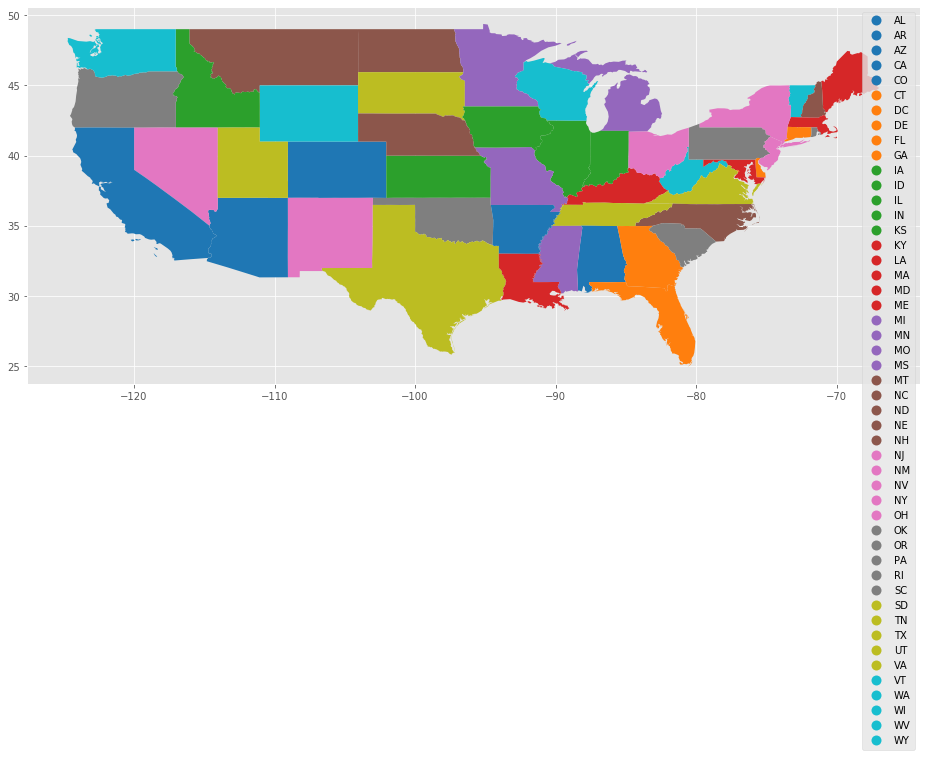

In [12]:
geo_df.plot(column='STATE_ABBR', categorical=True, legend=True)
plt.show()

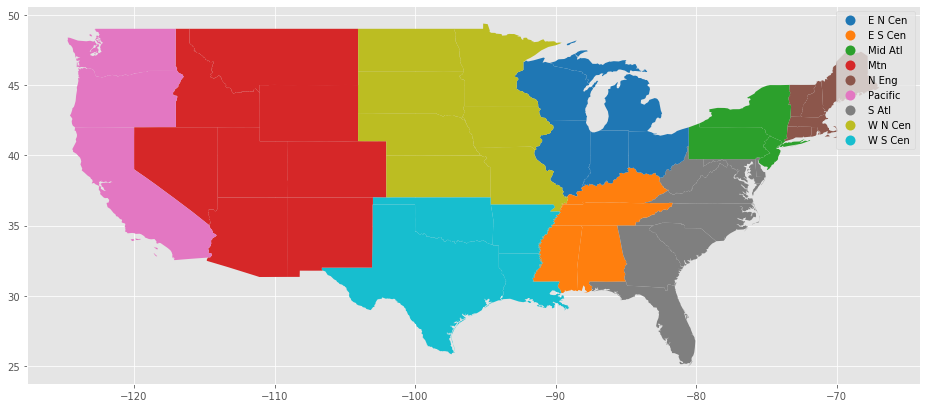

In [13]:
geo_df.plot(column='SUB_REGION', categorical=True, legend=True)
plt.show()

In [14]:
wkts = (lambda g: g.to_wkt(), geo_df.geometry)
#wkts = map(lambda g: g.to_wkt(), geo_df.geometry)
wkts[0]
type(geo_df.geometry)

geopandas.geoseries.GeoSeries

In [15]:
geo_df.crs={'init': 'epsg:4326'}

In [16]:
geo_df.crs

{'init': 'epsg:4326'}

In [17]:
geo_df.geometry.area

0     15.396467
1      0.017770
2      0.553318
3      6.493195
4      2.625117
5     28.041027
6     10.645120
7     21.981892
8     10.512136
9     18.647593
10    28.858782
11    18.031206
12    12.627803
13    10.876448
14    65.059583
15    30.936483
16    12.897116
17    11.870990
18    14.598796
19     7.794398
20    13.517338
21    11.224646
22    13.347714
23    16.927960
24    45.131676
25     9.570610
26    21.874284
27    22.597693
28    27.965643
29    16.477302
30    24.390738
31     2.794099
32    25.576939
33    28.187028
34     2.677289
35    15.853172
36     2.309183
37    21.606405
38    13.874600
39    12.550054
40     1.392486
41     0.292620
42     2.056683
43     9.931907
44    29.969229
45    22.966968
46    41.533085
47    11.299889
48    20.749828
dtype: float64

In [18]:
#geo_df['wkt'] = pd.Series((lambda geom: str(geom.to_wkt()), geo_df['geometry']),index=geo_df.index, dtype='string')
#geo_df['wkt'] =(lambda geom: str(geom.to_wkt()), geo_df['geometry'])
#g: g.to_wkt()

In [19]:
# drop the geometry column because Spark can't infer a schema for it
df = geo_df.drop("geometry", axis=1)

df.columns

Index(['STATE_NAME', 'STATE_FIPS', 'SUB_REGION', 'STATE_ABBR', 'LAND_KM',
       'WATER_KM', 'PERSONS', 'FAMILIES', 'HOUSHOLD', 'MALE', 'FEMALE',
       'WORKERS', 'DRVALONE', 'CARPOOL', 'PUBTRANS', 'EMPLOYED', 'UNEMPLOY',
       'SERVICE', 'MANUAL', 'P_MALE', 'P_FEMALE', 'SAMP_POP'],
      dtype='object')

In [20]:
spark_df = spark.createDataFrame(df).cache()

In [21]:
spark_df.printSchema()

root
 |-- STATE_NAME: string (nullable = true)
 |-- STATE_FIPS: string (nullable = true)
 |-- SUB_REGION: string (nullable = true)
 |-- STATE_ABBR: string (nullable = true)
 |-- LAND_KM: double (nullable = true)
 |-- WATER_KM: double (nullable = true)
 |-- PERSONS: double (nullable = true)
 |-- FAMILIES: double (nullable = true)
 |-- HOUSHOLD: double (nullable = true)
 |-- MALE: double (nullable = true)
 |-- FEMALE: double (nullable = true)
 |-- WORKERS: double (nullable = true)
 |-- DRVALONE: double (nullable = true)
 |-- CARPOOL: double (nullable = true)
 |-- PUBTRANS: double (nullable = true)
 |-- EMPLOYED: double (nullable = true)
 |-- UNEMPLOY: double (nullable = true)
 |-- SERVICE: double (nullable = true)
 |-- MANUAL: double (nullable = true)
 |-- P_MALE: double (nullable = true)
 |-- P_FEMALE: double (nullable = true)
 |-- SAMP_POP: double (nullable = true)



In [22]:
CO_rdd = spark_df.filter(spark_df['STATE_NAME'] == 'Colorado')

In [23]:
CO_rdd.first()

Row(STATE_NAME='Colorado', STATE_FIPS='08', SUB_REGION='Mtn', STATE_ABBR='CO', LAND_KM=268659.501, WATER_KM=960.364, PERSONS=3294394.0, FAMILIES=854214.0, HOUSHOLD=1282489.0, MALE=1631295.0, FEMALE=1663099.0, WORKERS=1233023.0, DRVALONE=1216639.0, CARPOOL=210274.0, PUBTRANS=46983.0, EMPLOYED=1633281.0, UNEMPLOY=99438.0, SERVICE=421079.0, MANUAL=181760.0, P_MALE=0.495, P_FEMALE=0.505, SAMP_POP=512677.0)

In [24]:
CO_rdd.count()

1

In [25]:
#wkt.loads(CO_rdd.take(1)[0].wkt)

In [26]:
states_pop = spark_df.select(
             spark_df['STATE_NAME'],
             spark_df['UNEMPLOY'].cast(IntegerType()))

In [27]:
states_pop = states_pop.sort(states_pop['UNEMPLOY'].desc())
states_pop.show()

+--------------+--------+
|    STATE_NAME|UNEMPLOY|
+--------------+--------+
|    California|  996502|
|      New York|  636280|
|         Texas|  590269|
|      Illinois|  385040|
|      Michigan|  374341|
|       Florida|  356769|
|  Pennsylvania|  344795|
|          Ohio|  324867|
|    New Jersey|  218598|
| Massachusetts|  218000|
|       Georgia|  187390|
|     Louisiana|  175303|
|North Carolina|  163081|
|       Indiana|  160143|
|      Missouri|  155388|
|     Tennessee|  152128|
|      Kentucky|  148125|
|      Virginia|  141926|
|    Washington|  139216|
|     Wisconsin|  129191|
+--------------+--------+
only showing top 20 rows



In [28]:
states_pop.createOrReplaceTempView("states")

In [29]:
spark.sql("""
          SELECT STATE_NAME, UNEMPLOY
          FROM states 
          ORDER BY UNEMPLOY desc""").show()

+--------------+--------+
|    STATE_NAME|UNEMPLOY|
+--------------+--------+
|    California|  996502|
|      New York|  636280|
|         Texas|  590269|
|      Illinois|  385040|
|      Michigan|  374341|
|       Florida|  356769|
|  Pennsylvania|  344795|
|          Ohio|  324867|
|    New Jersey|  218598|
| Massachusetts|  218000|
|       Georgia|  187390|
|     Louisiana|  175303|
|North Carolina|  163081|
|       Indiana|  160143|
|      Missouri|  155388|
|     Tennessee|  152128|
|      Kentucky|  148125|
|      Virginia|  141926|
|    Washington|  139216|
|     Wisconsin|  129191|
+--------------+--------+
only showing top 20 rows



In [30]:
df = states_pop.toPandas()

In [31]:
df.head(10)

,STATE_NAME,UNEMPLOY
0,California,996502
1,New York,636280
2,Texas,590269
3,Illinois,385040
4,Michigan,374341
5,Florida,356769
6,Pennsylvania,344795
7,Ohio,324867
8,New Jersey,218598
9,Massachusetts,218000


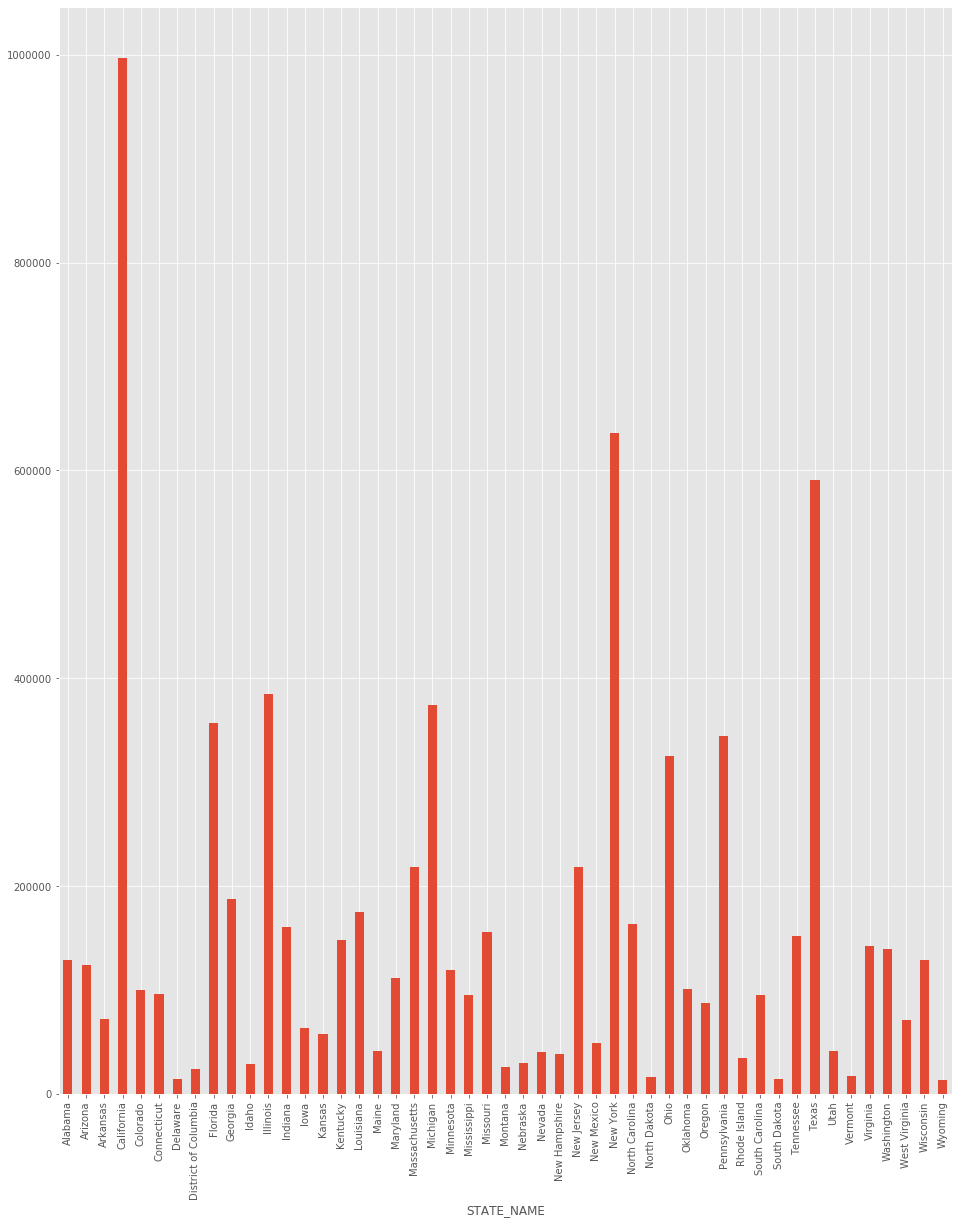

In [32]:
df.groupby('STATE_NAME')['UNEMPLOY'].mean().plot(kind='bar')
plt.show()
#df.plot(kind='bar',x=df['UNEMPLOY'], legend=True)

In [33]:
#plt.show()

In [34]:
#df.plot(x='STATE_NAME', y='UNEMPLOY')
#plt.show()

#fig, ax = plt.subplots()
#df.groupby('UNEMPLOY').plot(x='STATE_NAME', y='UNEMPLOY', ax=ax, legend=False)